In [138]:
# Import necessary modules

import os
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

import torch.nn.functional as F


In [139]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
import os
import torch

from pytorch3d.transforms.so3 import (
    so3_exp_map,
    so3_relative_angle,
    so3_log_map,
)


In [ ]:
# Input Convex Neural Network

class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]**2)) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()
        

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        
        xr = torch.reshape(x,(-1,))
        z = F.linear(xr, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(xr, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(xr, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]

# Rectified Huber unit - modified ReLU to make it smooth    
class ReHU(nn.Module):
    """ Rectified Huber unit"""
    def __init__(self, d):
        super().__init__()
        self.a = 1/d
        self.b = -d/2

    def forward(self, x):
        return torch.max(torch.clamp(torch.sign(x)*self.a/2*x**2,min=0,max=-self.b),x+self.b)

# Adding a quadratic term to make it PSD    
class MakePSD(nn.Module):
    def __init__(self, f, n, eps=0.01, d=1.0, w1 = 1.0, w2 = 1.0):
        super().__init__()
        self.f = f
        self.zero = torch.nn.Parameter(f(torch.eye(3, dtype = torch.float32)), requires_grad=False)
        self.eps = eps
        self.d = d
        self.rehu = ReHU(self.d)
        self.w1 = w1
        self.w2 = w2

    def forward(self, x):
        smoothed_output = self.rehu(self.f(x) - self.zero)
        quadratic_under = self.eps*torch.trace(torch.eye(3, dtype = torch.float32)-x) #self.eps*(x**2).sum(1,keepdim=True)
        return self.w1*smoothed_output + self.w2*quadratic_under



def configure():

    lsd = 3
    ph_dim = 100 #16 
    
    V = MakePSD(ICNN([lsd, ph_dim, ph_dim, 1], activation=ReHU(0.01)), lsd, eps = 0.0, d = 1.0, w1 = 1.0, w2 = 1.0)
    

    #V = nn.Sequential(nn.Linear(lsd, ph_dim, bias=False), nn.LeakyReLU(),
    #    nn.Linear(ph_dim, lsd, bias=False), nn.LeakyReLU(),
    #    PosDefICNN([lsd, ph_dim, ph_dim, 1], eps=projfn_eps, negative_slope=0.3))

    
    global potentialFunction
    potentialFunction = V  

    


In [ ]:
class Dynamics(nn.Module):
    
    def __init__(self, differentiable_model, J =  torch.eye(3, dtype = torch.float32), Kd = torch.eye(3, dtype = torch.float32), Rd = torch.eye(3, dtype = torch.float32), nSim = 100, dt = 0.01):
        super().__init__()

        self.differentiable_model = differentiable_model
        self.J = J
        self.Kd = Kd
        self.Rd = Rd
        self.nSim = nSim
        self.dt = dt
        
    def proportionalControl(self, R):
        
        '''
        R is the current rotaton matrix state
        Rd is the desired rotation matrix 
        '''
        
        '''
        create a lie algebra element eta and move along eta by eps
        take limit eps --> 0
        differentiate wrt eta to obtain the gradient (should be the same for any eta) 
        
        '''

        
        # epsilon for obtaining the limit for a small variation
        eps = torch.tensor(0.0, dtype = torch.float32, requires_grad = True)
        
        # direction (lie algebra element) along which the variation is taken
        #eta = torch.randn(1, 3, dtype=torch.float32, requires_grad = True)
        
        eta = torch.tensor([[1.0, 1.0, 1.0]], dtype = torch.float32, requires_grad = True)
        
        # variation
        delta_R = so3_exp_map(eta*eps)[0]
        #delta_Rinv = torch.linalg.inv(delta_R)
        
        # y+dy 
        y = self.differentiable_model(0.5*(self.Rd.permute(1,0)@R@delta_R+delta_R.permute(1,0)@R.permute(1,0)@self.Rd)) # traditional forward pass
        
        # lt eps -> 0 (y+dy(eps) - y)/ eps
        dydeps = torch.autograd.grad(y, eps , create_graph = True)[0]
        
        # grad_eta (dy.eta) = dy
        d1Phi = torch.autograd.grad(dydeps, eta, create_graph = True)[0]
        #print("---------------")
        #print(torch.norm(d1Phi))

        return -d1Phi.permute(1,0)
    
    def derivativeControl(self, R, omega):
        
        dControl = -self.Kd@omega
        #print(torch.norm(dControl))
        
        return dControl
    
    def dynamicalModel(self, R, omega, T):

        # Angular Velocity at next step
        omegaPlus = omega + torch.linalg.inv(self.J)@(torch.linalg.cross(self.J@omega,omega,dim = 0) + T) * self.dt
        #omegaPlus = omega +   T * self.dt
        
        # rotation matrix at next step
        RPlus = R@so3_exp_map(omega.permute(1,0)*self.dt)[0]
        
        return RPlus,omegaPlus
    
    def forward(self, R0, omega0):
    
        #R_mat = torch.zeros(3,3,self.nSim, dtype = torch.float32, requires_grad = False)
    
        #omega_mat = torch.zeros(3,1,self.nSim, dtype = torch.float32, requires_grad = False)
        
        R,omega = {},{}
    
        R['e0'] = R0
        omega['e0'] = omega0
    
    
        for i in range(self.nSim-1):
        
            T = self.proportionalControl(R['e'+str(i)]) + self.derivativeControl(R['e'+str(i)], omega['e'+str(i)])
            
            R['e'+str(i+1)], omega['e'+str(i+1)] = self.dynamicalModel(R['e'+str(i)], omega['e'+str(i)], T)
            

        return R, omega
    
    
def loss(RPredicted, RDesired, omegaPredicted,  omegaDesired, w_omega):
    
    l = {}
    for key0 in RPredicted:
        for key1 in RPredicted[key0]:
            l[key0+key1] = torch.norm(RPredicted[key0][key1]-RDesired[key0][key1])**2+w_omega*torch.norm(omegaPredicted[key0][key1]-omegaDesired[key0][key1])**2
    
    return sum(l.values())

In [142]:
configure()

# Inertia Tensor
J = torch.diag(torch.tensor([2.0,0.5,0.5], dtype = torch.float32, requires_grad = False))
nSim = 100
dt = 0.1
Kd = torch.diag(torch.tensor([1,1,1], dtype = torch.float32, requires_grad = False))
RDes = torch.eye(3, dtype = torch.float32, requires_grad = False)
omegaDes = torch.zeros(3,1, dtype = torch.float32, requires_grad = False)

model = Dynamics(potentialFunction, J, Kd, RDes, nSim, dt)

In [143]:
nData = 50

R0_Data = torch.zeros(3,3,nData, dtype = torch.float32)
omega0_Data = torch.zeros(3,1,nData, dtype = torch.float32)


for i in range(nData):
    R0_Data[:,:,i] = so3_exp_map(torch.randn(1,3, dtype = torch.float32))
    omega0_Data[:,:,i] = torch.randn(3,1, dtype = torch.float32)
    
R0_Data.requires_grad = True
omega0_Data.requires_grad = True

In [144]:
RDesTraj, omegaDesTraj = {},{} 

for i in range(nSim):
    RDesTraj['e'+str(i)] = RDes
    omegaDesTraj['e'+str(i)] = omegaDes
    RDesTraj['e'+str(i)].requires_grad = True
    omegaDesTraj['e'+str(i)].requires_grad = True

In [221]:
learning_rate = 0.001
n_iters = 100
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)
w_omega = 1
#loss = nn.MSELoss()


for epochs in range(n_iters):
    
    # prediction = forward pass
    
    #R_predicted = torch.zeros(3,3,nSim,nData, dtype = torch.float32)
    #omega_predicted = torch.zeros(3,1,nSim,nData, dtype = torch.float32)
    
    

    #R_actual = torch.zeros(3,3,nSim,nData, dtype = torch.float32)
    #omega_actual = torch.zeros(3,1,nSim,nData, dtype = torch.float32)
    
    RPredicted = {}
    omegaPredicted = {}
    
    RDesired = {}
    omegaDesired = {}
    
    l1 = {}
    
    for j in range(nData):
        RPredicted['e'+str(j)], omegaPredicted['e'+str(j)] = model(R0_Data[:,:,j], omega0_Data[:,:,j])
        RDesired['e'+str(j)], omegaDesired['e'+str(j)] = RDesTraj, omegaDesTraj
    
    l = loss(RPredicted, RDesired,omegaPredicted, omegaDesired, w_omega)/nData
    
    #print(l)

    
    # gradients = backward pass
    l.backward(retain_graph=True)
    
    #with torch.no_grad():
    #    w-= learning_rate*w.grad
    
    # instead 
    optimizer.step()
        
    # zero gradients
    #w.grad.zero_()
    optimizer.zero_grad()
    
    if epochs%1==0:
        print('epoch number',epochs,',loss = ', l)

epoch number 0 ,loss =  tensor(130.4917, grad_fn=<DivBackward0>)
epoch number 1 ,loss =  tensor(133.0563, grad_fn=<DivBackward0>)
epoch number 2 ,loss =  tensor(131.6359, grad_fn=<DivBackward0>)
epoch number 3 ,loss =  tensor(131.1273, grad_fn=<DivBackward0>)
epoch number 4 ,loss =  tensor(131.7378, grad_fn=<DivBackward0>)
epoch number 5 ,loss =  tensor(131.7490, grad_fn=<DivBackward0>)
epoch number 6 ,loss =  tensor(131.5178, grad_fn=<DivBackward0>)
epoch number 7 ,loss =  tensor(131.2471, grad_fn=<DivBackward0>)
epoch number 8 ,loss =  tensor(130.9805, grad_fn=<DivBackward0>)
epoch number 9 ,loss =  tensor(131.0504, grad_fn=<DivBackward0>)
epoch number 10 ,loss =  tensor(131.0801, grad_fn=<DivBackward0>)
epoch number 11 ,loss =  tensor(131.0325, grad_fn=<DivBackward0>)
epoch number 12 ,loss =  tensor(130.8272, grad_fn=<DivBackward0>)
epoch number 13 ,loss =  tensor(130.7244, grad_fn=<DivBackward0>)
epoch number 14 ,loss =  tensor(130.7252, grad_fn=<DivBackward0>)
epoch number 15 ,los

In [222]:
# Benchmark Network
    
def configure_benchmark():
    
    lsd = 3
    ph_dim = 1 #16
    
    V = MakePSD(ICNN([lsd, ph_dim, 1], activation=ReHU(0.01)), lsd, eps = 1.0, d = 1.0, w1 = 0.0, w2 = 1.0)
    

    #V = nn.Sequential(nn.Linear(lsd, ph_dim, bias=False), nn.LeakyReLU(),
    #    nn.Linear(ph_dim, lsd, bias=False), nn.LeakyReLU(),
    #    PosDefICNN([lsd, ph_dim, ph_dim, 1], eps=projfn_eps, negative_slope=0.3))

    
    global potentialFunction2
    potentialFunction2 = V    

    


In [223]:
configure_benchmark()
model2 = Dynamics(potentialFunction2, J, Kd, RDes, nSim, dt)

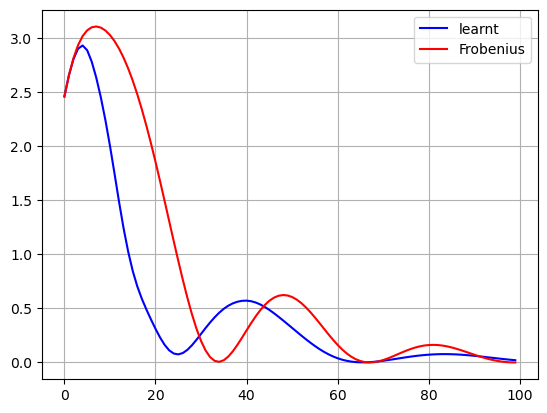

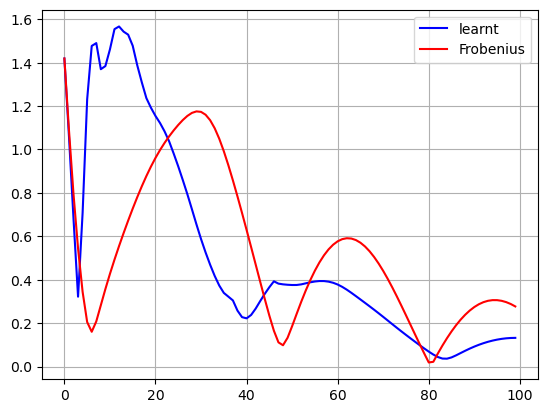

In [228]:
R0_test = so3_exp_map(torch.randn(1,3, dtype = torch.float32, requires_grad = True))[0]
omega0_test = torch.randn(3,1, dtype = torch.float32, requires_grad = True)

#print(R0_test, omega0_test)

#R_NN, omega_NN = model(R0_Data[:,:,3], omega0_Data[:,:,3])
#R_benchmark, omega_benchmark = model2(R0_Data[:,:,3], omega0_Data[:,:,3])
R_NN, omega_NN = model(R0_test, omega0_test)
R_benchmark, omega_benchmark = model2(R0_test, omega0_test)


Psi_NN = torch.zeros(nSim, dtype = torch.float32)
Psi_benchmark = torch.zeros(nSim, dtype = torch.float32)

errorKE_NN = torch.zeros(nSim, dtype = torch.float32)
errorKE_benchmark = torch.zeros(nSim, dtype = torch.float32)

for i in range(len(R_NN)):
    Psi_NN[i] = potentialFunction2(R_NN['e'+str(i)])
    Psi_benchmark[i] = potentialFunction2(R_benchmark['e'+str(i)])
    
    errorKE_NN[i] = torch.norm(omega_NN['e'+str(i)])
    errorKE_benchmark[i] = torch.norm(omega_benchmark['e'+str(i)])
    
plt.plot(Psi_NN.detach().numpy(), 'b-', label='learnt')
plt.plot(Psi_benchmark.detach().numpy(), 'r-', label='Frobenius')
plt.grid()
plt.legend()
plt.show()

plt.plot(errorKE_NN.detach().numpy(), 'b-', label='learnt')
plt.plot(errorKE_benchmark.detach().numpy(), 'r-', label='Frobenius')
plt.grid()
plt.legend()
plt.show()
    
    
    
    


# log 1

ph_dim = 16, eps = 1, d = 1.0, w1 = 1, w2 = 1
nSim = 50
dt = 0.1
Kd = torch.diag(torch.tensor([1,1,1], dtype = torch.float32, requires_grad = False))
nData = 50
learning_rate = 0.1
n_iters = 10

benchmark
ph_dim = 16, eps = 1, d = 1.0, w1 = 0, w2 = 1

# log 2

ph_dim = 40, eps = 1, d = 1.0, w1 = 1, w2 = 1
nSim = 50
dt = 0.2
Kd = torch.diag(torch.tensor([1,1,1], dtype = torch.float32, requires_grad = False))
nData = 50
learning_rate = 0.01
n_iters = 10

benchmark
ph_dim = 40, eps = 1, d = 1.0, w1 = 0, w2 = 1

# log 3

ph_dim = 100, eps = 1, d = 1.0, w1 = 1, w2 = 1
nSim = 100
dt = 0.1
Kd = torch.diag(torch.tensor([1,1,1], dtype = torch.float32, requires_grad = False))
nData = 50
learning_rate = 0.01
n_iters = 10

benchmark
ph_dim = 100, eps = 1, d = 1.0, w1 = 0, w2 = 1


